# Analysis and Modeling 
Goal:
In this notebook, we perform both the analytical exploration and modeling part of the project.
The first part includes exploratory data analysis (EDA) to understand the distribution of key variables and potential relationships in the data.
In the second part, a logistic regression model is applied using statsmodels to identify significant factors associated with loan default.

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [3]:
# read the csv-file
df = pd.read_csv('../data/processed/credit_risk_cleaned.csv')
print(df.shape)
df.head()

(32566, 13)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,default,credit_history,age_group
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,0,2,<25
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,0,3,<25
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,0,2,<25
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.64,1,4,<25
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,0,2,<25


In [144]:
# descriptve statistics
pd.set_option('display.float_format', '{:.0f}'.format)
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,default,credit_history
count,32566,32566,32566,32566,32566,32566,32566,32566,32566
mean,28,65522,5,9588,11,0,0,0,6
std,6,47103,4,6321,3,0,0,0,4
min,20,4000,0,500,5,0,0,0,2
25%,23,38500,2,5000,8,0,0,0,3
50%,26,55000,4,8000,11,0,0,0,4
75%,30,79200,7,12200,13,0,0,0,8
max,94,948000,41,35000,23,1,1,1,30


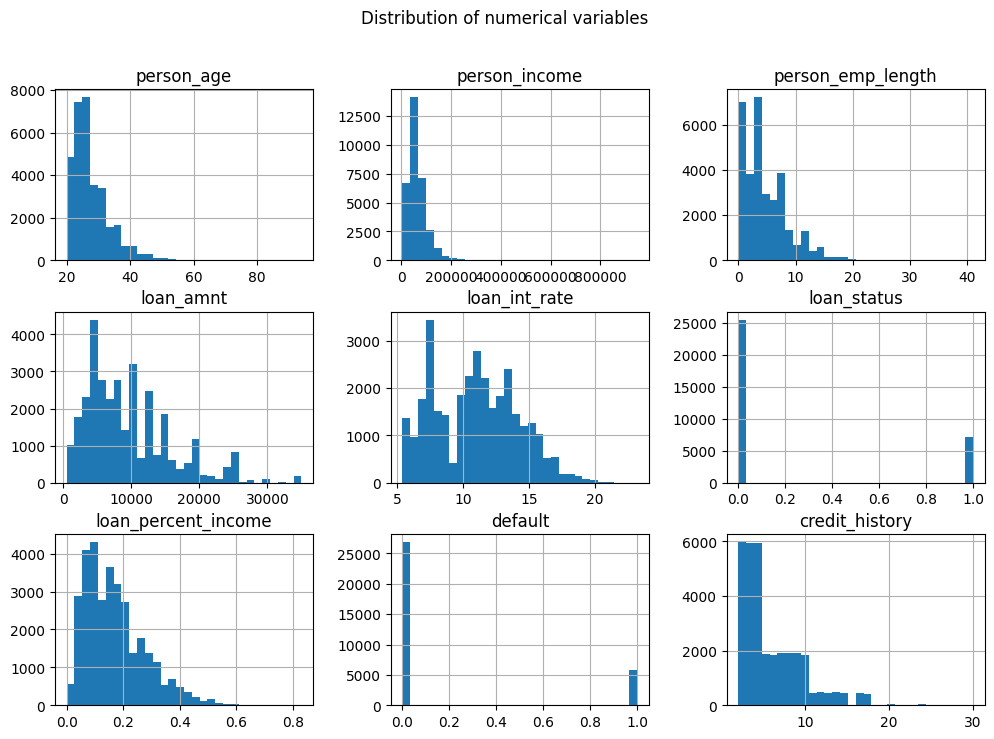

In [145]:
# distributions 
df.hist(figsize=(12,8), bins=30)
plt.suptitle('Distribution of numerical variables')
plt.show;

Past defaults:  default
0    26823
1     5743
Name: count, dtype: int64
Actual defaults: 
 loan_status
0    25459
1     7107
Name: count, dtype: int64
Default rate:  17.63



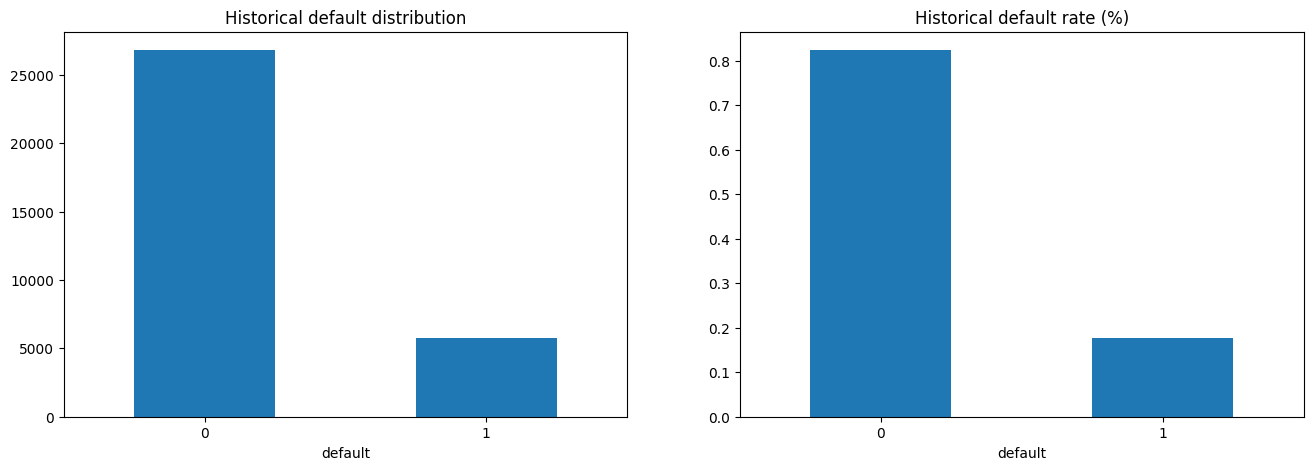

In [8]:
# Distribution of past defaults
fig, ax = plt.subplots(ncols=2,figsize=(16,5))

default_abs = pd.crosstab(index=df['default'],columns='count')
default_pc = pd.crosstab(index=df['default'],columns='count',normalize='columns')
hist_avg_default = round((df['default'].mean()*100),2)

print('Past defaults: ',df['default'].value_counts())
print('Actual defaults: \n',df['loan_status'].value_counts())
print('Default rate: ', hist_avg_default)


default_abs.plot(kind='bar',
                 legend=False,
                 title='Historical default distribution',
                 ax=ax[0])
default_pc.plot(kind='bar',
                legend=False,
                title='Historical default rate (%)',
                ax=ax[1])

ax[0].xaxis.set_tick_params(labelrotation=0)
ax[1].xaxis.set_tick_params(labelrotation=0);

print()


The chart shows the distribution of borrowers by historical default status.   
Most customers had no prior default ~82%, while around 18% had previously defaulted.

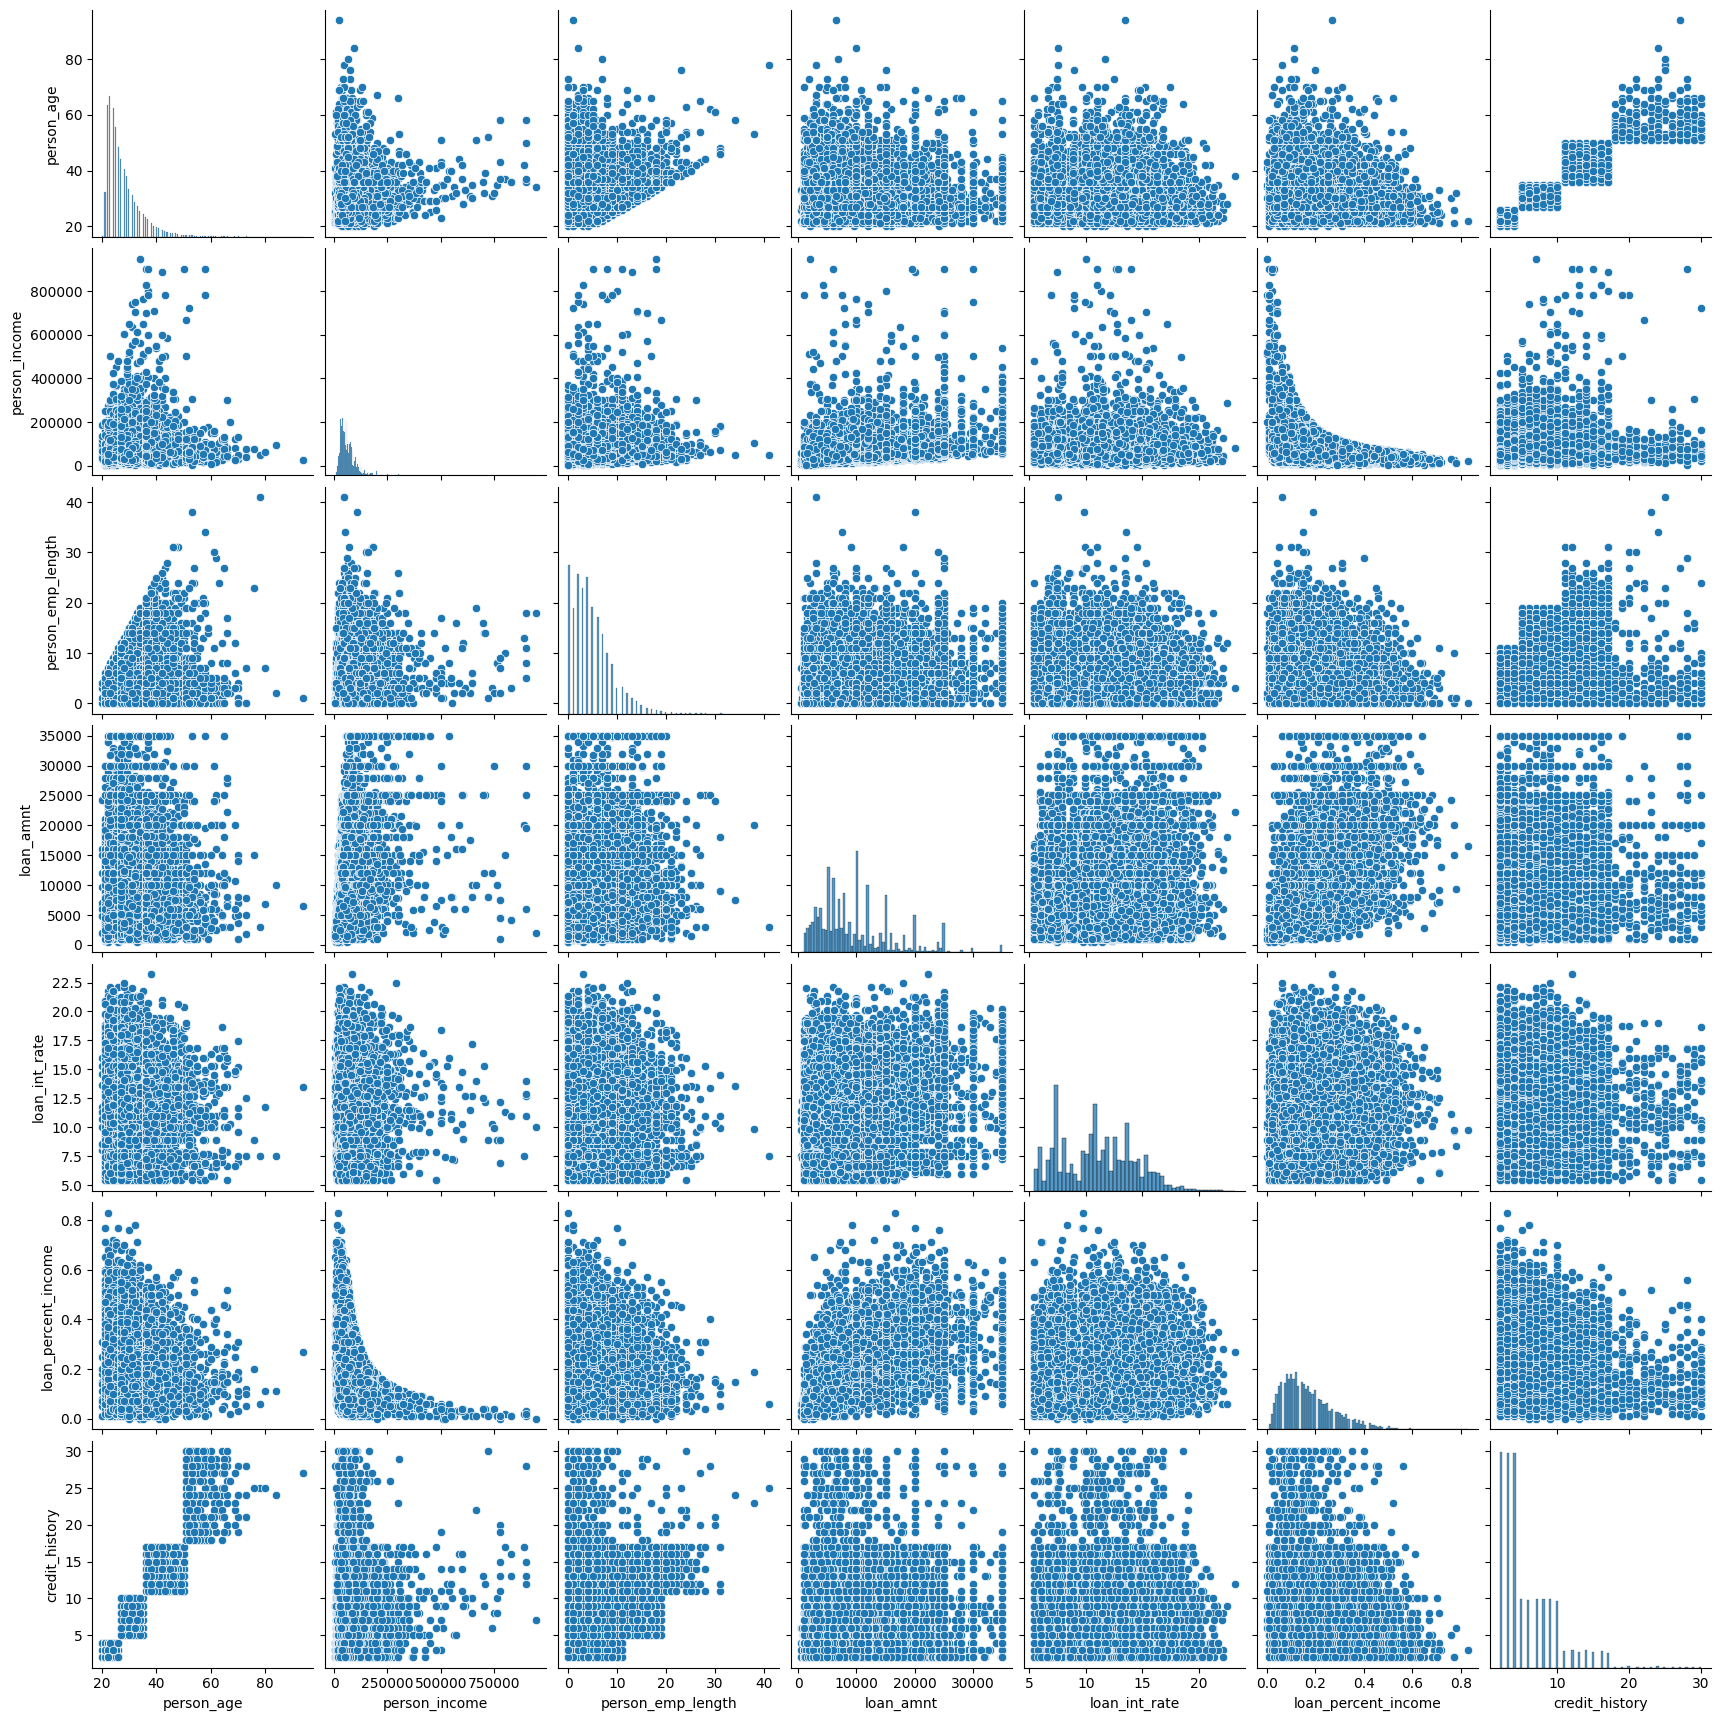

In [147]:
# Pairplot
num_cols = df[['person_age', 'person_income', 'person_emp_length', 
           'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
           'credit_history']]

sns.pairplot(num_cols);

Most variables show weak or no correlations

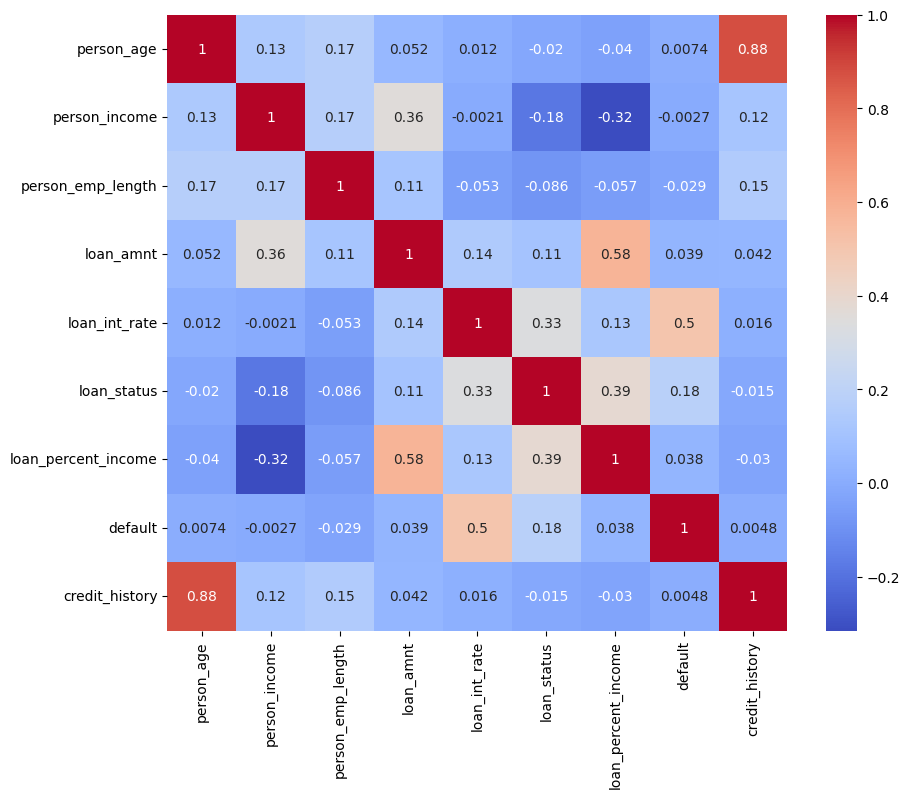

In [148]:
# Heatmap
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

The heatmap shows several notable relationships with the target ('loan_status'):
'loan_int_rate' and 'loan_status' (actual default) correlate around 0.33  
'loan_percent_income' and 'loan_status' correlate around 0.39
'loan_int_rate' and historical default ('default') have a strong relationship (0.50)

Interest rate and the loan_percent_income share are meaningful predictors of default: borrowers with higher interest rates and with a larger share of income dedicated to loan payments are more likely to default. Historical default (past behaviour) also strongly indicates current risk.
Because 'loan_status' is binary, a logistic regression is appropriate as a baseline model. Both 'loan_int_rate' and 'loan_percent_income' are good candidates for initial models given their moderate correlations with the target.

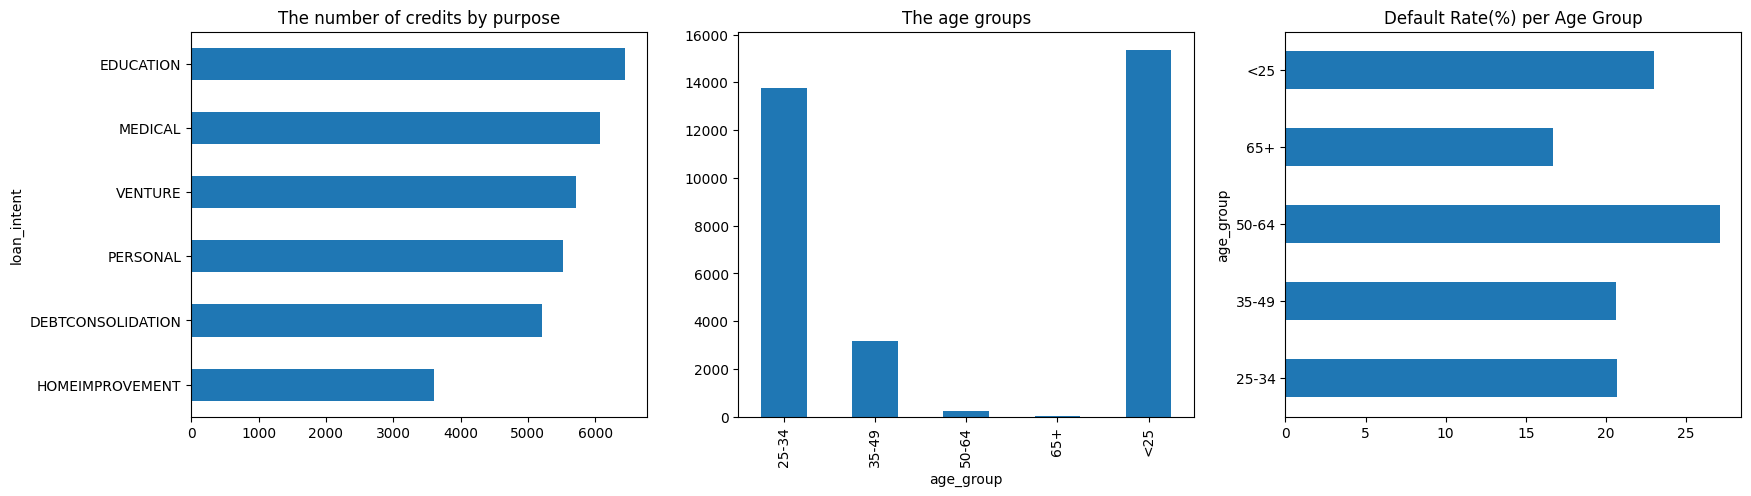

In [149]:
# categorical variables
# credit purposes, age gropus
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
loan_type = pd.crosstab(index=df['loan_intent'],
                        columns='count').sort_values('count')
agegroup_count = pd.crosstab(index=df['age_group'],columns='count')
default_rate = df.groupby('age_group')['loan_status'].mean() * 100

loan_type.plot(kind='barh',title='The number of credits by purpose',legend=False,ax=ax[0])
agegroup_count.plot(kind='bar',title='The age groups',legend=False,ax=ax[1])
default_rate.plot(kind='barh',title='Default Rate(%) per Age Group', ax=ax[2]);


Loan purposes are dominated by education and medical needs.
The borrower base is predominantly young.
Default risk across age groups: higher among the youngest and near-retirement borrowers, lower in the middle age ranges.

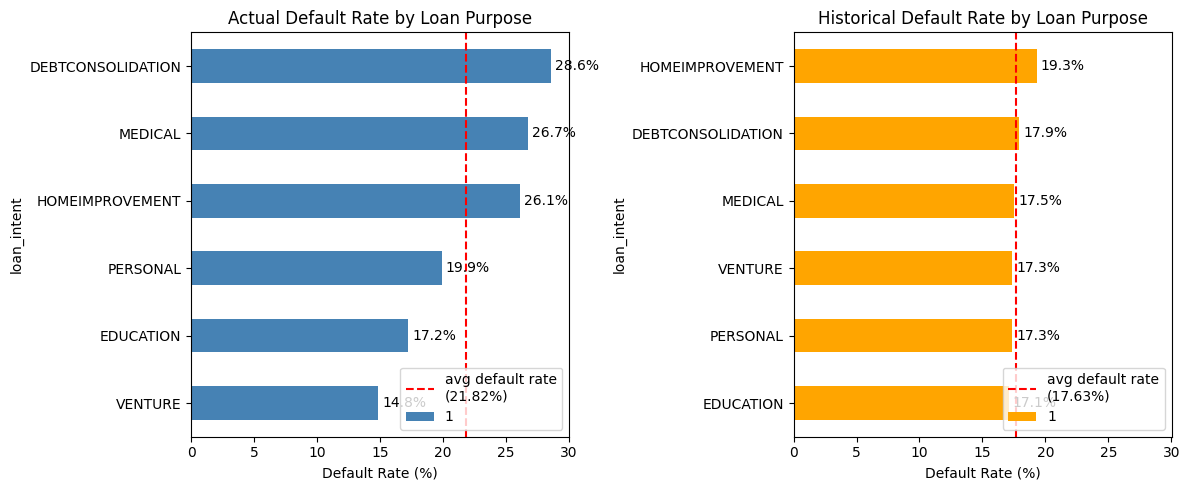

In [150]:
# purpose of loan with the most default

# avarage actual default rate
avg_status_rate = df['loan_status'].mean()*100

# visual
fig, ax = plt.subplots(ncols=2, figsize=(12,5),sharex=True) 

loan_type = ((pd.crosstab(index=df['loan_intent'],
                        columns=df['loan_status'],
                        normalize='index'))*100).sort_values(by=1)
loan_type_hist = ((pd.crosstab(index=df['loan_intent'],
                        columns=df['default'],
                        normalize='index'))*100).sort_values(by=1)

loan_type[1].plot(kind='barh',
                   title='Actual Default Rate by Loan Purpose',
                   xlabel='Default Rate (%)',
                   color='steelblue',ax=ax[0])
loan_type_hist[1].plot(kind='barh',
                          title='Historical Default Rate by Loan Purpose',
                          xlabel='Default Rate (%)',
                          color='orange',ax=ax[1])

# put percentage labels on the bars
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)


# show avarage line    
ax[0].axvline(avg_status_rate, color='red',
              linestyle='--', 
              label=f'avg default rate\n({avg_status_rate:.2f}%)')
ax[0].legend(loc='lower right')
ax[1].axvline(hist_avg_default, color='red',
              linestyle='--', 
              label=f'avg default rate\n({hist_avg_default:.2f}%)')
ax[1].legend(loc='lower right');
plt.tight_layout()


Loan Intent
Loans for debt consolidation, medical and home improvement purposes have the highest default rates, whereas personal, education and venture loans show lower-than-average risk.

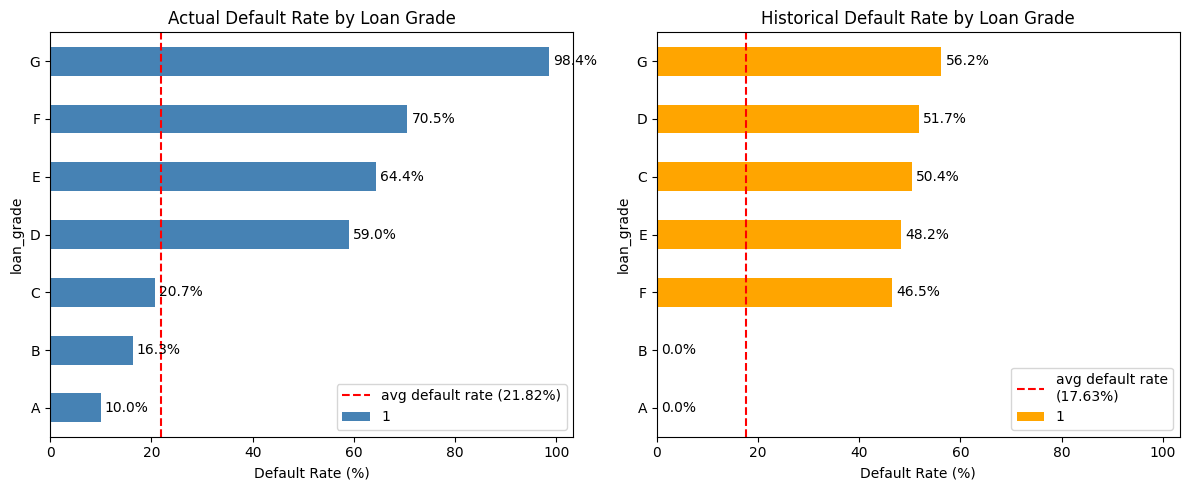

In [151]:
# which loan grade has the most defaults
fig, ax = plt.subplots(ncols=2, figsize=(12,5),sharex=True) 

loan_grade = ((pd.crosstab(index=df['loan_grade'],
                        columns=df['loan_status'],
                        normalize='index'))*100).sort_values(by=1)
loan_grade_hist = ((pd.crosstab(index=df['loan_grade'],
                        columns=df['default'],
                        normalize='index'))*100).sort_values(by=1)

loan_grade[1].plot(kind='barh',
                   title='Actual Default Rate by Loan Grade',
                   xlabel='Default Rate (%)',
                   color='steelblue',ax=ax[0])
loan_grade_hist[1].plot(kind='barh',
                          title='Historical Default Rate by Loan Grade',
                          xlabel='Default Rate (%)',
                          color='orange',ax=ax[1])

# put percentage labels on the bars
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

# show avarage line
ax[0].axvline(avg_status_rate, color='red', 
              linestyle='--', 
              label=f'avg default rate ({avg_status_rate:.2f}%)')
ax[0].legend(loc='lower right')
ax[1].axvline(hist_avg_default, color='red',
              linestyle='--', 
              label=f'avg default rate\n({hist_avg_default:.2f}%)')
ax[1].legend(loc='lower right');
plt.tight_layout()

Loan Grade
Borrowers with lower grades (D–G) show a much higher actual default rate than the average, while grades A–C are associated with considerably fewer defaults.

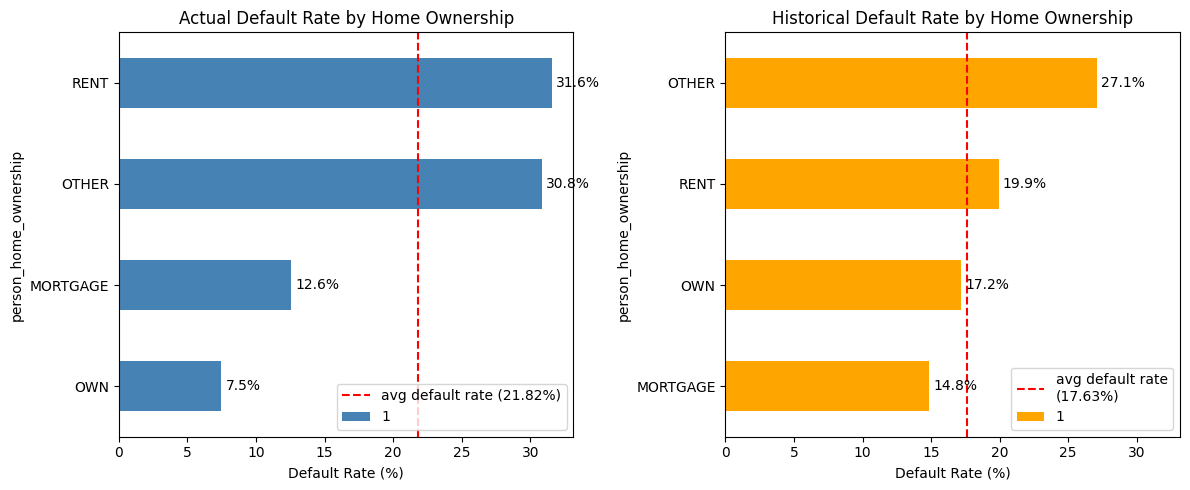

In [152]:
# which typeof home ownership have the most defaults?
fig, ax = plt.subplots(ncols=2, figsize=(12,5),sharex=True) 
home_owner = ((pd.crosstab(index=df['person_home_ownership'],
                            columns=df['loan_status'], 
                            normalize='index'))*100).sort_values(by=1)
home_owner_hist = ((pd.crosstab(index=df['person_home_ownership'],
                            columns=df['default'], 
                            normalize='index'))*100).sort_values(by=1)


home_owner[1].plot(kind='barh',
                   title='Actual Default Rate by Home Ownership',
                   xlabel='Default Rate (%)',
                   color='steelblue',ax=ax[0])
home_owner_hist[1].plot(kind='barh',
                          title='Historical Default Rate by Home Ownership',
                          xlabel='Default Rate (%)',
                          color='orange',ax=ax[1])

# put percentage labels on the bars
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

# show avarage line
ax[0].axvline(avg_status_rate, color='red', 
              linestyle='--', 
              label=f'avg default rate ({avg_status_rate:.2f}%)')
ax[0].legend(loc='lower right')
ax[1].axvline(hist_avg_default, color='red',
              linestyle='--', 
              label=f'avg default rate\n({hist_avg_default:.2f}%)')
ax[1].legend(loc='lower right');
plt.tight_layout()

Customers with RENT or OTHER show a significantly higher actual default rate than the average, while homeowners default significantly less often.

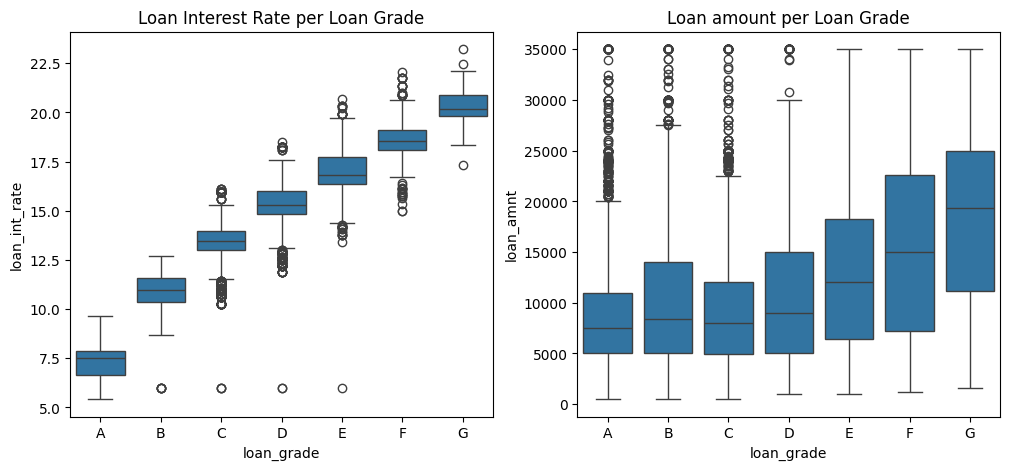

In [153]:
# Loan grade and interest rate 
fig, ax = plt.subplots(ncols=2, figsize=(12,5))

my_order1 = df.groupby(by=['loan_grade'])['loan_int_rate'].median().iloc[:].index
my_order2 = df.groupby(by=['loan_grade'])['loan_amnt'].median().iloc[:].index

sns.boxplot(x='loan_grade', y='loan_int_rate', data=df,order=my_order1,ax=ax[0])
ax[0].set(title='Loan Interest Rate per Loan Grade')

sns.boxplot(x='loan_grade', y='loan_amnt', data=df,order=my_order2,ax=ax[1])
ax[1].set(title='Loan amount per Loan Grade');

There is a clear positive relationship between loan grade and interest rate. From A to G the interest rate increases significantly - so higher grades  → higher interest rates → higher risk.
The analysis shows that loan amounts increase from grades E to G, suggesting that borrowers with lower credit grades tend to take larger loans.
This pattern may indicate higher financial risk and more aggressive lending strategies toward less creditworthy applicants.

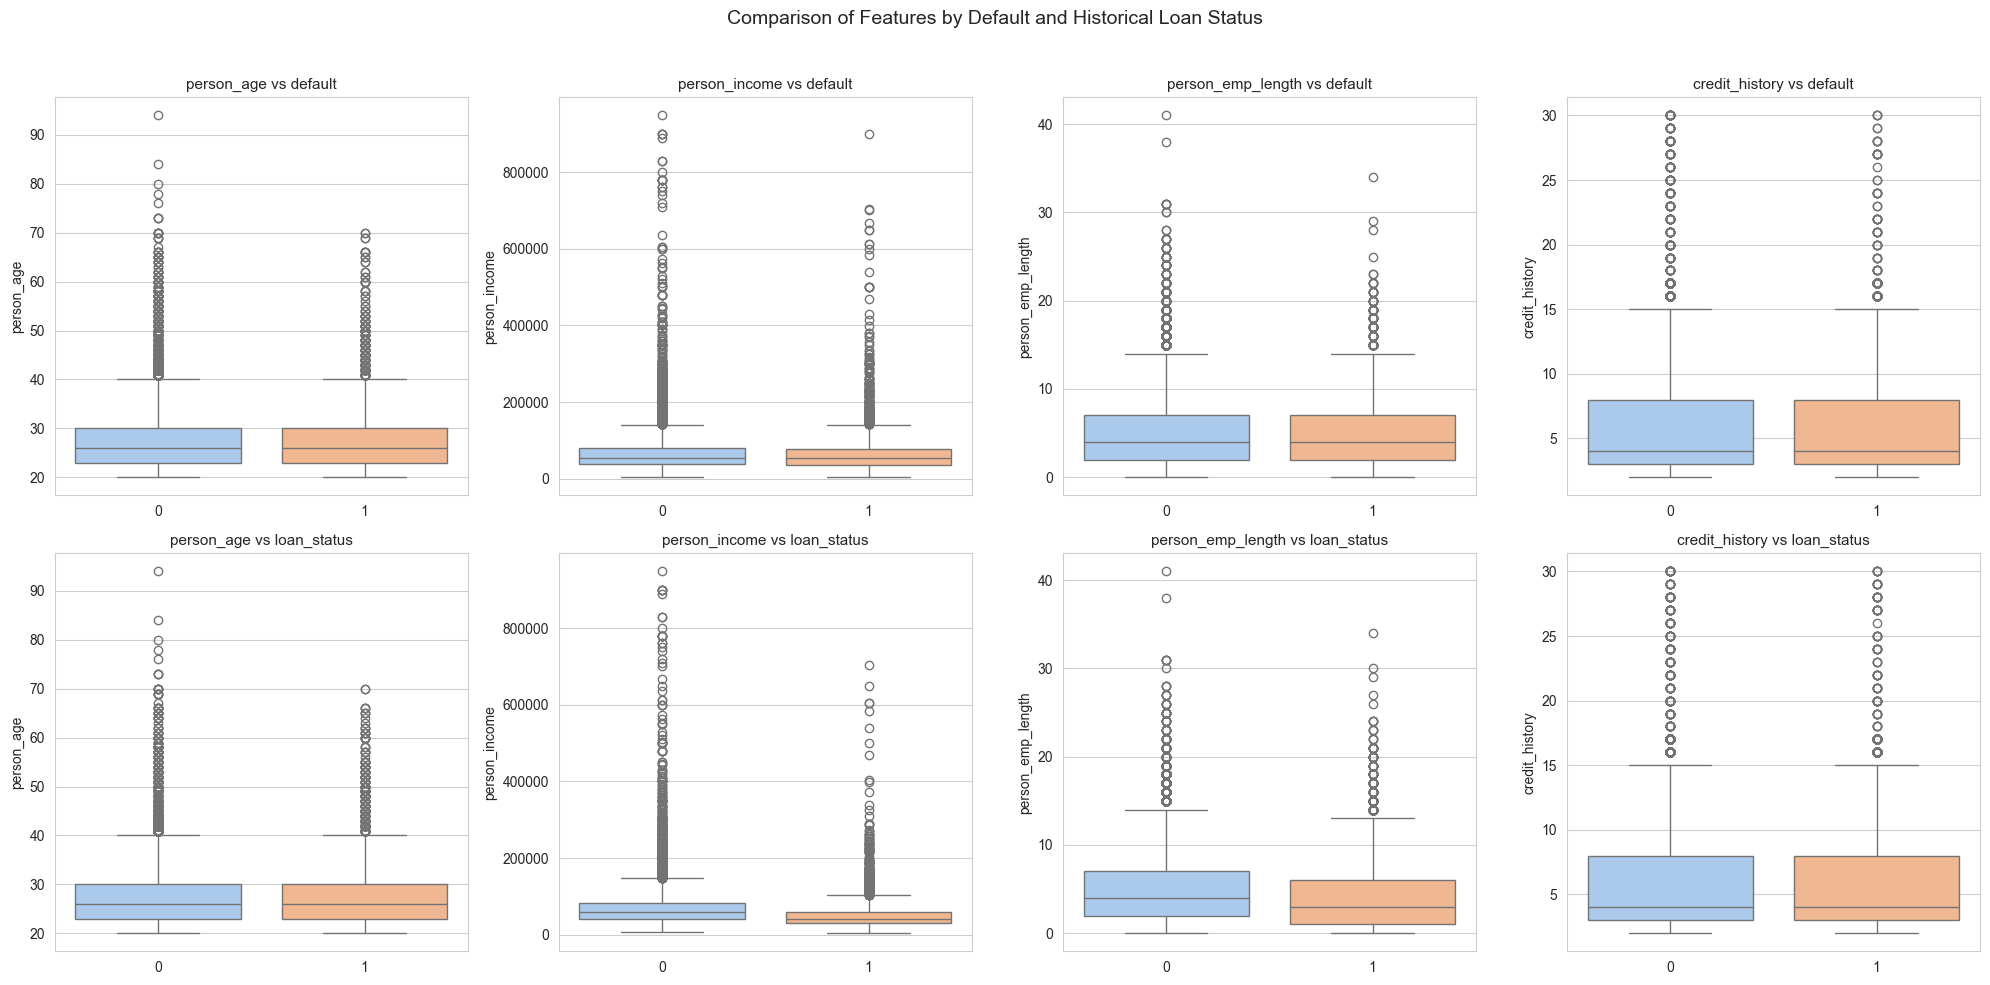

In [154]:
# Comparison of Features by Default and Historical Loan Status
sns.set_style("whitegrid")

features = ['person_age', 'person_income', 'person_emp_length', 'credit_history']
targets = ['default', 'loan_status']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for row, target in enumerate(targets):
    for col, feature in enumerate(features):
        sns.boxplot(
            data=df,
            x=target,
            y=feature,
            palette='pastel',
            ax=axes[row, col],
            hue=target,
            legend=False
        )
        axes[row, col].set_title(f'{feature} vs {target}', fontsize=11)
        axes[row, col].set_xlabel('')
        axes[row, col].set_ylabel(feature)

plt.suptitle('Comparison of Features by Default and Historical Loan Status', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

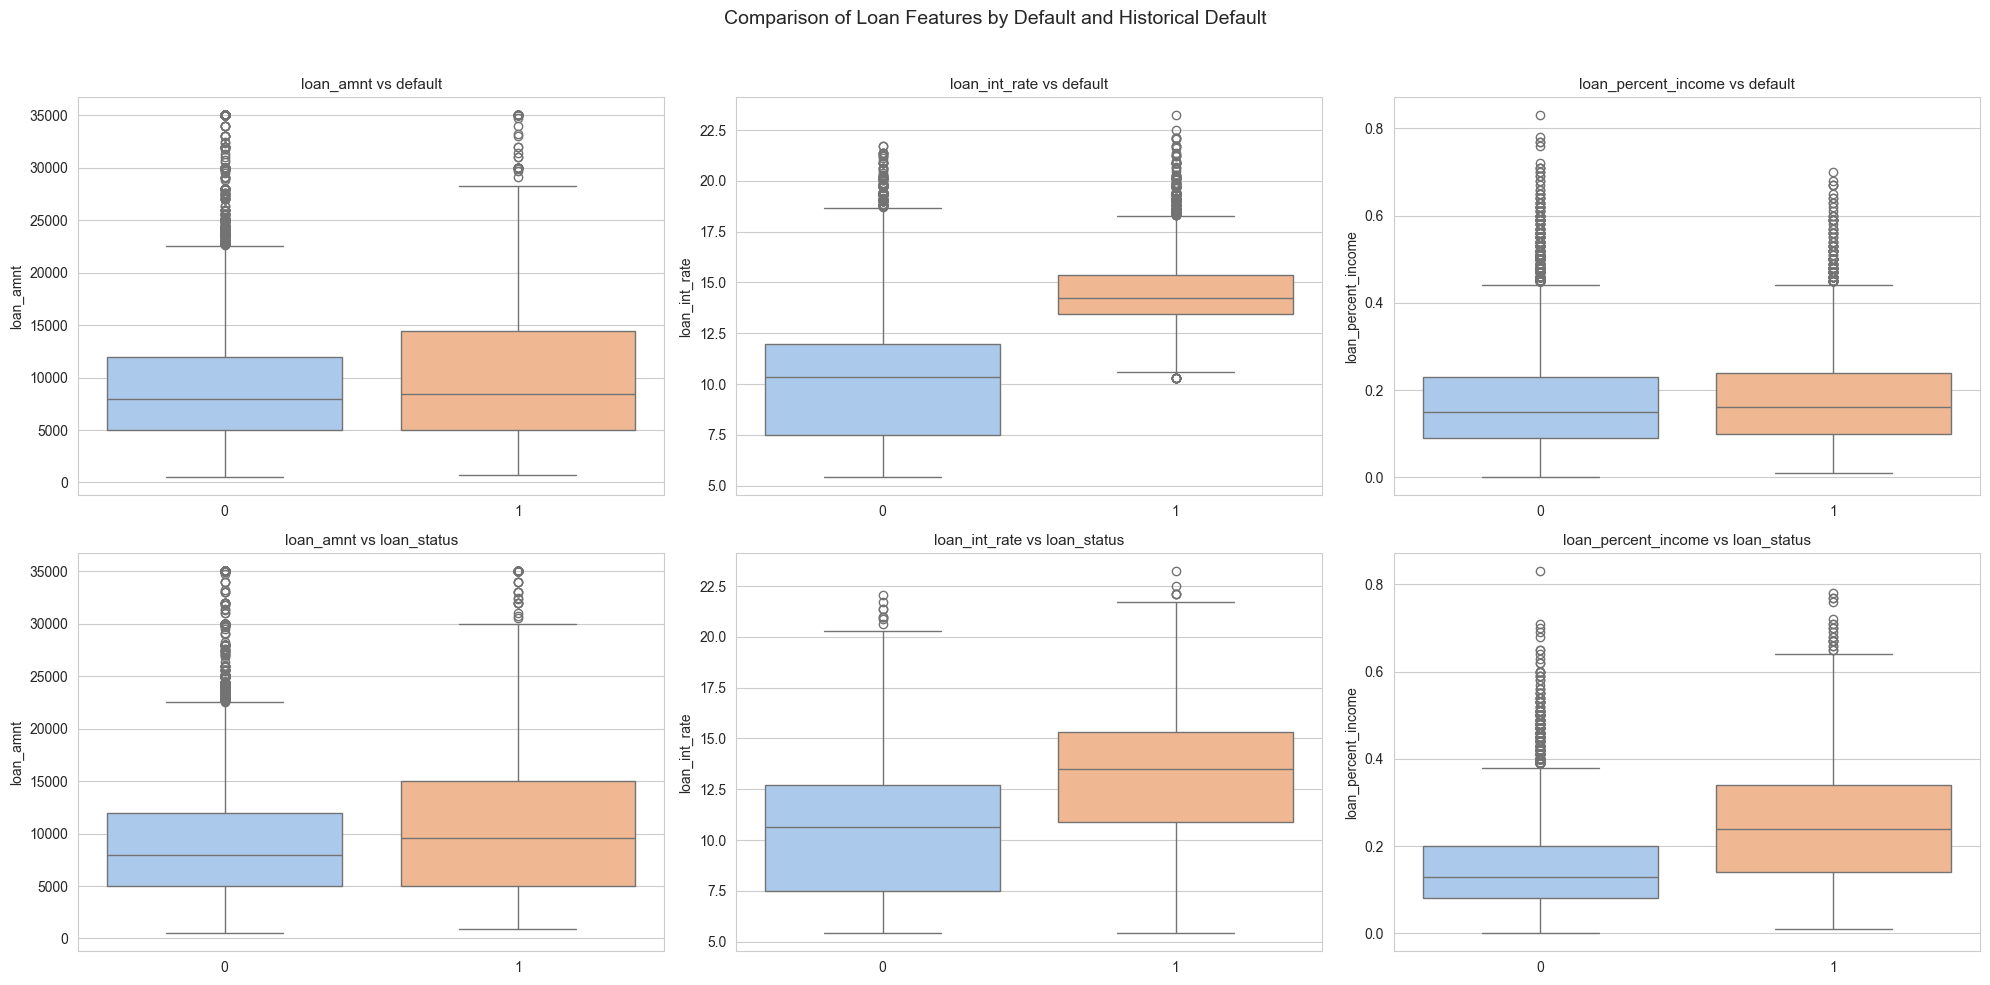

In [155]:

# boxplots of loan features
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
features = ['loan_amnt', 'loan_int_rate', 'loan_percent_income']
targets = ['default', 'loan_status']

for row, target in enumerate(targets):
    for col, feature in enumerate(features):
        sns.boxplot(
            data=df,
            x=target,
            y=feature,
            palette='pastel',
            ax=axes[row, col],
            hue=target,
            legend=False
        )
        axes[row, col].set_title(f'{feature} vs {target}', fontsize=11)
        axes[row, col].set_xlabel('')
        axes[row, col].set_ylabel(feature)

plt.suptitle('Comparison of Loan Features by Default and Historical Default', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Boxplots for 'loan_int_rate' and 'loan_percent_income' vs. 'loan_status' show clear differences between defaulters and non-defaulters, reinforcing their predictive importance for modeling credit risk.

Although some outliers are visible, they were retained because they may represent valid customer cases rather than errors.

loan_status          0          1
default                          
0            81.597882  18.402118
1            62.197458  37.802542 

Avarage default rate:  21.82 



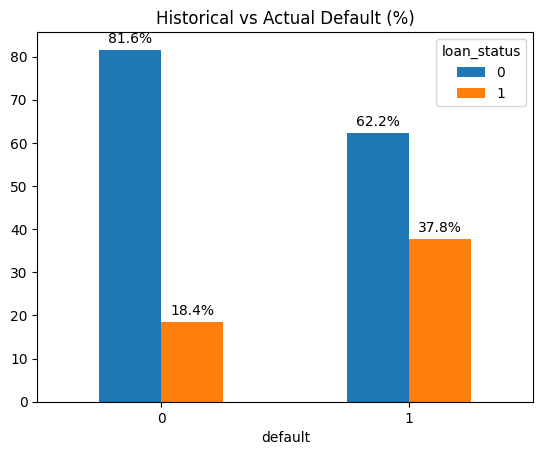

In [9]:
# historical vs actual default
fig,ax = plt.subplots()

avg_status_rate = df['loan_status'].mean()*100
hist_act_default = (pd.crosstab(df['default'], df['loan_status'], normalize='index')) * 100

print(hist_act_default,'\n')
print('Avarage default rate: ',round(avg_status_rate,2),'\n')
hist_act_default.plot(kind='bar',ax=ax)

# put percentage labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

plt.title('Historical vs Actual Default (%)')
plt.xticks(rotation=0);


Borrowers with a past default history are about twice as likely to default again.
This confirms that historical behavior is a strong risk indicator — which aligns with real-world credit scoring logic.

Loan_percent_income ratio is dominant factor associated with default probability.

In [11]:
model = smf.logit('loan_status ~ loan_percent_income', data=df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.454510
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                32566
Model:                          Logit   Df Residuals:                    32564
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 Oct 2025   Pseudo R-squ.:                  0.1337
Time:                        15:59:24   Log-Likelihood:                -14802.
converged:                       True   LL-Null:                       -17086.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.9186      0.032    -90.798      0.000      -2.982      -2.856
loan_percent_income     8.5139      0.137     62.001      0.000       8.245       8.783
=======================================================================================
"""

In [158]:
model1 = smf.logit('loan_status ~ loan_int_rate', data=df)
results1 = model1.fit()
results1.summary()

Optimization terminated successfully.
         Current function value: 0.467312
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                32566
Model:                          Logit   Df Residuals:                    32564
Method:                           MLE   Df Model:                            1
Date:                Mon, 13 Oct 2025   Pseudo R-squ.:                  0.1093
Time:                        17:23:51   Log-Likelihood:                -15218.
converged:                       True   LL-Null:                       -17086.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.4784      0.062    -72.605      0.000      -4.599      -4.357
loan_int_rate     0.2727      0.005     56.205      0.000       0.263       0.282
=================================================================================
"""

Logistic Regression Results: 
Modeling of the probability of loan default ('loan_status') using two predictors: 
loan to income ration and loan interest rate.

The results show that all predictors are statistically significant. 
Higher interest rates and higher loan-to-income ratios substantially increase the likelihood of default. 

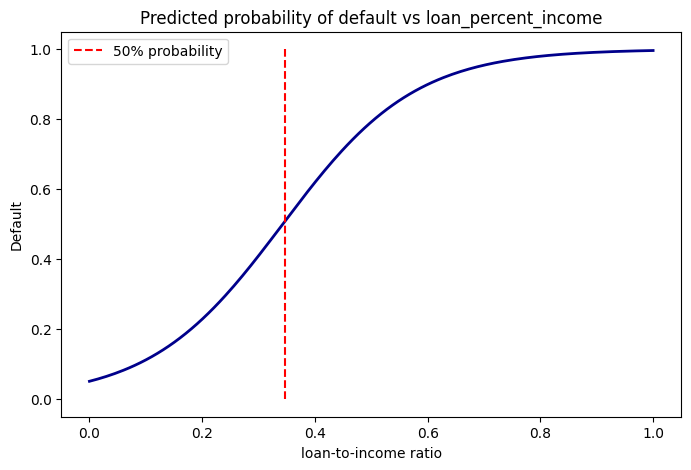

Loan_percent_income at 50% probability: 0.347


In [12]:
X = np.linspace(0, 1, 200)
X_df = pd.DataFrame(X)
X_df.columns = ['loan_percent_income']
p_y = results.predict(X_df)

fig, ax = plt.subplots(figsize=(8,5))

# plot predicted probability
ax.plot(X_df['loan_percent_income'], p_y, color='darkblue', linewidth=2)

# 50% threshold
x_50 = X_df['loan_percent_income'][p_y >= 0.5].iloc[0]
ax.vlines(x=x_50, ymin=0, ymax=1, colors='red', linestyles='--', label='50% probability')

# labels
ax.set_xlabel('loan-to-income ratio')
ax.set_ylabel('Default')
ax.set_title('Predicted probability of default vs loan_percent_income')
ax.legend()

plt.show()

# print tipping point
print(f"Loan_percent_income at 50% probability: {x_50:.3f}")

Modeling of the probability of loan default (loan_status) using loan_percent_income. The pseudo R² is 0.13, indicating a modest but meaningful fit.
Borrowers with a loan-to-income ratio above ~0.35 have a high risk of default according to the model.

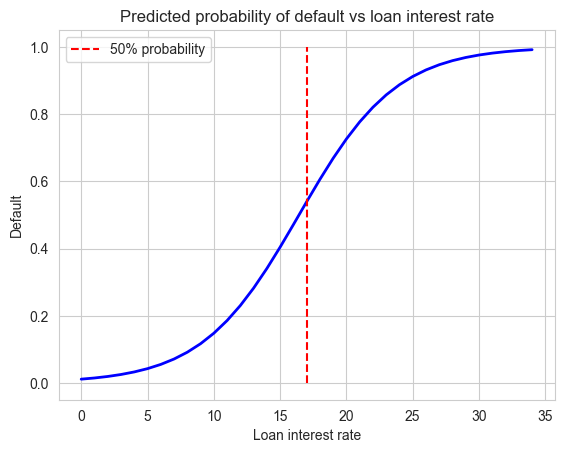

Loan_int_rate at 50% probability: 17.0%


In [160]:
# Generate range for loan_percent_income
X1 = pd.Series(range(35))
X_df1 = pd.DataFrame(X1)
X_df1.columns = ['loan_int_rate']

# Predict probabilities using fitted model
p_y1 = results1.predict(X_df1)

# plot predicted probability
fig, ax = plt.subplots()

# 50% threshold
ax=p_y1.plot(color='blue', linewidth=2)
ax.vlines(x=p_y1[p_y1>=0.5].index[0],ymin=0,ymax=1,colors='red', linestyles='--', label='50% probability');              

# labels
ax.set_xlabel('Loan interest rate')
ax.set_ylabel('Default')
ax.set_title('Predicted probability of default vs loan interest rate')
ax.legend()

plt.show()

# print tipping point
print(f"Loan_int_rate at 50% probability: {p_y1[p_y1>=0.5].index[0]:.1f}%")

Modeling of the probability of loan default (loan_status) using loan_int_rate. The pseudo R² is 0.10, indicating a modest but meaningful fit.
Borrowers with a loan interest rate above 17% have a high risk of default according to the model.

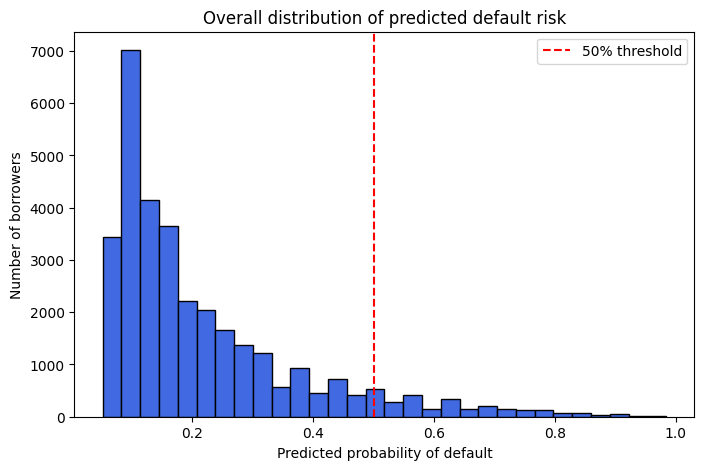

In [13]:
# Predict probabilities for each borrower
df['predicted'] = results.predict(df)

# Plot distribution
plt.figure(figsize=(8,5))
plt.hist(df['predicted'], bins=30, color='royalblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='50% threshold')

plt.title("Overall distribution of predicted default risk")
plt.xlabel("Predicted probability of default")
plt.ylabel("Number of borrowers")
plt.legend()
plt.show()

In [14]:
risky_count = (df['predicted'] >= 0.5).sum()
total_count = len(df)
risky_percent = risky_count / total_count * 100

print(f"{risky_count} borrowers ({risky_percent:.2f}%) are classified as high-risk.")

2451 borrowers (7.53%) are classified as high-risk.
